In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 깃헙 동기화 및 경로 설정

In [2]:
%cd /content/drive/MyDrive/Final_project
!git clone https://github.com/Slangoij/PlayData_Final_Project.git
%cd /content/drive/MyDrive/Final_project/PlayData_Final_Project

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project
fatal: destination path 'PlayData_Final_Project' already exists and is not an empty directory.
/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


In [3]:
%cd BASE_PATH

[Errno 2] No such file or directory: 'BASE_PATH'
/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


In [4]:
# # 잘못 저장해서 루트 디렉토리에 다른 파일 지울 용도
# %cd /content/drive/MyDrive
# import os
# filename_in_dir = os.listdir('/content/drive/MyDrive')
# # for i in filename_in_dir:
# #   print(i)
# for fname in filename_in_dir:
#   now = os.path.splitext(fname)
#   if now[-1]=='.png' or now[-1]=='.pb':
#     os.remove(fname)

# 파라미터 및 데이터 경로 설정

In [13]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, ResNet50V2, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 하이퍼 파라미터
LEARNING_RATE = 0.001
N_EPOCHS = 50
N_BATCHS = 200
NUM_CLASSES = 4 # 클래스 개수
CLASS_MODE = 'categorical'
INPUT_SHAPE = (640, 360, 3) # 학습할 이미지 shape
########################### 모델에 맞춰 변경해야 한다!
FEATURE_SHAPE = (20, 15, 512)

BASE_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project'
ORIGINAL_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/inputdata_preprocessing/img'
AUGMENT_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/inputdata_preprocessing/augmentImg'
train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

In [14]:
%pwd

'/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project'

# 함수:  특성추출, 분류기 모델 생성

In [15]:
def get_generators():
    '''
    train, validation, test generator를 생성해서 반환.
    train generator는 image 변환 처리
    '''
    # 상하좌우 이동, 확대, 회전 이미지로 증강
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=5,
                                       zoom_range=0.5,
                                       height_shift_range=0.3,
                                       width_shift_range=0.3,
                                       fill_mode='nearest')
    
    test_datagen = ImageDataGenerator(rescale=1/255) #validation/test에서 사용

    # generator 들 생성
    # 첫번째는 먼저 한동작이므로 동작과 비동작으로 바이너리 구분만
    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=INPUT_SHAPE[:2],
                                                        batch_size=N_BATCHS,
                                                        class_mode=CLASS_MODE)    
    val_generator = test_datagen.flow_from_directory(validation_dir,
                                                     target_size=INPUT_SHAPE[:2],
                                                     batch_size=N_BATCHS,
                                                     class_mode=CLASS_MODE)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      target_size=INPUT_SHAPE[:2],
                                                      batch_size=N_BATCHS,
                                                      class_mode=CLASS_MODE)
    return train_generator, val_generator, test_generator


# 결과 출력
def plot_result(history, ymin=None, ymax=None):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)

    plt.plot(range(1,N_EPOCHS+1), history.history['loss'], label='train loss')
    plt.plot(range(1,N_EPOCHS+1), history.history['val_loss'], label='validation loss')
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, N_EPOCHS+1), history.history['accuracy'], label='train accuracy')
    plt.plot(range(1, N_EPOCHS+1), history.history['val_accuracy'], label='validation accuracy')
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if ymin!=None and ymax!=None:
        plt.ylim(ymin, ymax)
    plt.legend()

    plt.tight_layout()
    plt.show()

# 데이터 증강

In [16]:
%cd /content/drive/MyDrive/Final_project/PlayData_Final_Project

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


In [19]:
shutil.rmtree(AUGMENT_PATH, ignore_errors=True) # 디렉토리 비우기

# 데이터 증강
for subpath in os.listdir(ORIGINAL_PATH):
    os.makedirs(os.path.join(AUGMENT_PATH, subpath), exist_ok=True)
    data_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range=5,
                                      zoom_range=0.5,
                                      height_shift_range=0.3,
                                      width_shift_range=0.3,
                                      fill_mode='nearest')
    
    target_path = os.path.join(ORIGINAL_PATH, subpath)
    filename_in_dir = [] 
    for (root, dirs, files) in os.walk(target_path):
      for fname in files:
        full_fname = os.path.join(root, fname)
        filename_in_dir.append(full_fname)

    target_image_list = [fname for fname in filename_in_dir if os.path.splitext(fname)[-1]=='.png']
    # print(target_image_list)
    for file_image in target_image_list:
        img = load_img(file_image)
        x = img_to_array(img)
        x = x[np.newaxis, ...]
    
        i = 0
        for batch in data_datagen.flow(x, save_to_dir=os.path.join(AUGMENT_PATH, subpath), save_prefix='aug', save_format='png'):
          i += 1
          if i > 20: # 이 부분으로 증가시킬 양을 결정할 수 있다.
              break

In [20]:
for st in (os.listdir(AUGMENT_PATH)):
  print(len(os.listdir(os.path.join(AUGMENT_PATH, st))))

4714
4656
4697
4628


# 학습 이미지 정리(디렉토리, 이름, 파일 개수)

In [21]:
%cd /content/drive/MyDrive/Final_project/PlayData_Final_Project

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


In [ ]:
import random

# 학습데이터 및 모델 경로 설정
train_dir = './inputdata_preprocessing/classedImg/train'
validation_dir = './inputdata_preprocessing/classedImg/val'
test_dir = './inputdata_preprocessing/classedImg/test'

# 기존 데이터 디렉토리 지우기
shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(validation_dir, ignore_errors=True)
shutil.rmtree(test_dir, ignore_errors=True)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

img_file_list = os.listdir(AUGMENT_PATH)

for i in range(len(img_file_list)): # 모든 라벨(폴더)마다
  label = img_file_list[i]

  train_under_dir = os.path.join(train_dir, label)
  validation_under_dir = os.path.join(validation_dir, label)
  test_under_dir = os.path.join(test_dir, label)
  
  os.makedirs(train_under_dir, exist_ok=True)
  os.makedirs(validation_under_dir, exist_ok=True)
  os.makedirs(test_under_dir, exist_ok=True)

  tmp_img_path = os.path.join(AUGMENT_PATH, label)
  img_list = os.listdir(tmp_img_path)
  train_len = int(len(img_list)*0.7) # 70%를 train으로 넣어줌
  val_len = int(len(img_list)*0.9) # 나머지 20%를 train으로 넣어줌 나머지는 test
  random.shuffle(img_list)

  count = 0
  for img_name in img_list:
      if count < train_len:
        shutil.copy(os.path.join(tmp_img_path , img_name), os.path.join(train_under_dir, img_name)) # 이미지 copy
      elif count < val_len:
        shutil.copy(os.path.join(tmp_img_path , img_name), os.path.join(validation_under_dir, img_name))
      else:
        shutil.copy(os.path.join(tmp_img_path , img_name), os.path.join(test_under_dir, img_name))
      count += 1

# train, val, test 각 폴더 내 데이터 개수
data_cnts = []
for dirs in [train_dir, validation_dir, test_dir]:
  cnt = 0
  for (path, dir, files) in os.walk(dirs):
    cnt += len(files)
  data_cnts.append(cnt)

# 메인학습

In [ ]:
data_cnts

[4189, 1197, 599]

In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project'

In [ ]:
%cd '/content/drive/MyDrive/Final_project/PlayData_Final_Project'

/content/drive/.shortcut-targets-by-id/1M8PxNWOxRC7Du0zHac00XxeLLiSY6iXG/Final_project/PlayData_Final_Project


In [ ]:
train_iterator, validation_iterator, test_iterator = get_generators()

# 모델 학습 설정 콜백함수
MODEL_PATH = '/content/drive/MyDrive/Final_project/PlayData_Final_Project/model/vgg16'
if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH, exist_ok=True)
callback_path = os.path.join(MODEL_PATH, 'save_model_{epoch:02d}.ckpt')
# os.makedirs(callback_path, exist_ok=True)

mc_callback = keras.callbacks.ModelCheckpoint(callback_path, monitor='val_loss', save_best_only=True)

# 모델 생성
def create_model():
    conv_base = VGG16(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
    conv_base.trainable = False # 학습시 weight 최적화(update)를 하지 않도록 설정. => 모델 컴파일 전에 실행

    model = keras.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization()) # << 찾아보기
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

    return model

# 특성 추출 없이
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='categorical_crossentropy', # 클래스 따라 변경
              metrics=['accuracy'])
model.summary()

Found 4189 images belonging to 2 classes.
Found 1197 images belonging to 2 classes.
Found 599 images belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0     

In [ ]:
# # 최신 모델 불러오기
# model = keras.models.load_model(os.path.join(MODEL_PATH, 'save_model_13.ckpt'))
# # callback_path
# MODEL_PATH, os.path.dirname(MODEL_PATH)

In [ ]:
N_EPOCHS = 50
history = model.fit(train_iterator, epochs=N_EPOCHS,
                    steps_per_epoch=len(train_iterator),
                    validation_data=validation_iterator,
                    validation_steps=len(validation_iterator),
                    callbacks=[mc_callback])

Epoch 1/20
21/21 [==============================] - 60s 3s/step - loss: 0.5206 - accuracy: 0.7341 - val_loss: 0.3220 - val_accuracy: 0.9023
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final_project/PlayData_Final_Project/model/vgg16/save_model_01.ckpt/assets
Epoch 2/20
21/21 [==============================] - 60s 3s/step - loss: 0.5016 - accuracy: 0.7496 - val_loss: 0.3211 - val_accuracy: 0.9173
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final_project/PlayData_Final_Project/model/vgg16/save_model_02.ckpt/assets
Epoch 3/20
21/21 [==============================] - 60s 3s/step - loss: 0.5017 - accuracy: 0.7422 - val_loss: 0.3106 - val_accuracy: 0.9215
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Final_project/PlayData_Final_Project/model/vgg16/save_model_03.ckpt/assets
Epoch 4/20
21/21 [==============================] - 60s 3s/step - loss: 0.5086 - accuracy: 0.7486 - val_loss: 0.3602 - val_accuracy: 0.8454
Epoch 5/20
21/21 [=======================

In [ ]:
model = keras.models.load_model(os.path.join(MODEL_PATH, 'save_model_19.ckpt'))
# h5형식으로 저장
model_h5_path = os.path.join(MODEL_PATH, 'vgg16_model.h5')
model.save(model_h5_path, save_format='h5')

# evaluation
# 특성 미추출 모델로
model.evaluate(validation_iterator)
model.evaluate(test_iterator)

# # 특성추출 모델로
# whole_model.evaluate(validation_iterator)
# whole_model.evaluate(test_iterator)

3/3 [==============================] - 27s 13s/step - loss: 0.2698 - accuracy: 0.8932


[0.2697603702545166, 0.8931552767753601]

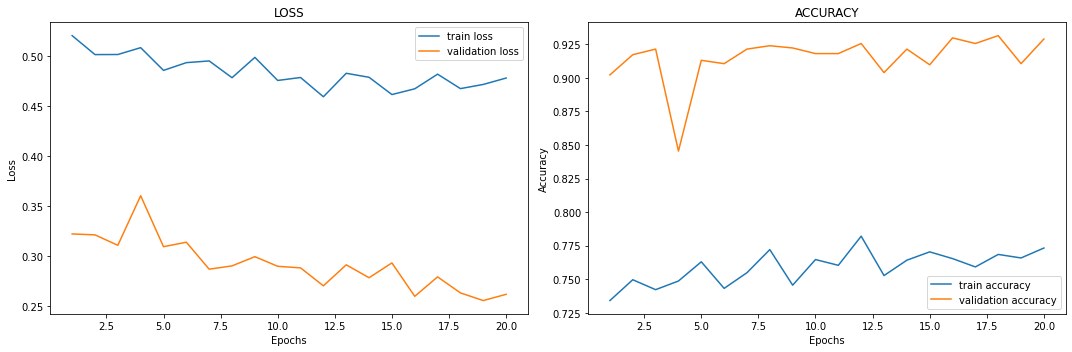

In [ ]:
plot_result(history)